# Assignment 3 - Evaluating Classification Models
MSDS 422 - SEC 57 THURSDAY

FERDYNAND HEBAL - 7/14/2019

In this assignment, linear regression, ridge regression, lasso regression, and elastic net regression are evaluated using root mean-squared error (RMSE) as an index of prediction error. All explanatory variables (with the exception of neighborhood) and all 506 census tract observations from the Boston Housing Study are used to predict the response variable: the median value of homes.

Regarding the management problem, these results suggest that plain linear regression is the better model given its low RMSE compared to the others. It is not regularized, however, and therefore at risk of overfitting. Regularized models like ridge, lasso, and elastic net regression offer some protection against overfitting and are generally preferred over plain linear regression. Model comparisons are detailed in the analysis and summary below

In [237]:
# Figure settings from Chapter 4 of the Géron (2017) textbook
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [238]:
# function to plot learning curves from Chapter 4 of the Géron (2017) textbook
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def plot_learning_curves(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
    train_errors, val_errors = [], []
    for m in range(1, len(X_train)):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_val, y_val_predict))
    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="val")

In [293]:
# function to print r2, RMSE and cross validation results
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn import metrics

def scoring(reg, y_test,X_test, y_train, X_train):
    y_pred = reg.predict(X_train)
    print("RMSE train",sqrt(mean_squared_error(y_train, y_pred)))
    y_pred = reg.predict(X_test)
    #print('r2',r2_score(y_test,y_pred))
    print("RMSE test",sqrt(mean_squared_error(y_test, y_pred)))
    scores = np.sqrt(-1 * cross_val_score(reg, X_test, y_test, cv=3, scoring =  'neg_mean_squared_error'))# Perform 6-fold cross validation
    print("Cross-validated RMSE on Test Data:")
    print(scores)
    print('\ny_test vs y_pred')
    predictions = cross_val_predict(reg, X_test, y_test, cv=3) # Make cross validated predictions
    plt.scatter(y_test, predictions)
    #accuracy = metrics.r2_score(y_test, predictions)

# Data preparation, exploration, visualization
Below I perform light data processing per the python starter code, including removal neighborhood feature and printing dataset detail using .head, .info, and .describe

In [294]:
#Starter code from Assignment page in canvas

# seed value for random number generators to obtain reproducible results
RANDOM_SEED = 1

# Although we standardize X and y variables on input, we will fit the intercept term in the models.
# Expect fitted values to be close to zero
SET_FIT_INTERCEPT = True

# import base packages into the namespace for this program
import numpy as np
import pandas as pd
import sklearn.linear_model 
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score  
from math import sqrt  # for root mean-squared error calculation

boston_input = pd.read_csv('boston.csv')
boston = boston_input.drop('neighborhood', 1)# drop neighborhood from the data being considered
boston_input.head()

,neighborhood,crim,zn,indus,chas,nox,rooms,age,dis,rad,tax,ptratio,lstat,mv
0,Nahant,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,4.98,24.0
1,Swampscott,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,9.14,21.6
2,Swanpscott,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,4.03,34.7
3,Marblehead,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,2.94,33.4
4,Marblehead,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,5.33,36.2


In [295]:
boston.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 13 columns):
crim       506 non-null float64
zn         506 non-null float64
indus      506 non-null float64
chas       506 non-null int64
nox        506 non-null float64
rooms      506 non-null float64
age        506 non-null float64
dis        506 non-null float64
rad        506 non-null int64
tax        506 non-null int64
ptratio    506 non-null float64
lstat      506 non-null float64
mv         506 non-null float64
dtypes: float64(10), int64(3)
memory usage: 51.5 KB


In [296]:
boston.describe()

,crim,zn,indus,chas,nox,rooms,age,dis,rad,tax,ptratio,lstat,mv
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,12.653063,22.528854
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,7.141062,9.182176
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,11.360000,21.200000
75%,3.677082,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,37.970000,50.000000


Per the starter code, response variable and 12 explanatory variables are selected for the model. Additional feature scaling transformation is applied to the entire dataset of all continuous data. As suggested by the Geron 2017 textbook, Machine Learning algorithms do not perform well when the input numerical attributes have very different scales. For example, gradient descent converges much faster with feature scaling than without it.
Furthermore, if a feature’s variance is orders of magnitude more than the variance of other features, that particular feature may dominate the other features. "StandardScaler" removes the mean and scales the data to unit variance, so that the variance of the features are approximately in the same range. The majority of classifiers, for example, calculate the Euclidean distance between two points. Data is normalized so that each feature contributes more or less proportionately to the final distance.

It should be noted however that outliers can have different magnitudes across different features and the spread of the transformed data on each feature can be different as a result. StandardScaler therefore cannot guarantee balanced feature scales in the presence of outliers, though it is much less affected by outlier than MinMax Scaling for example.

Source:
https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html#sphx-glr-auto-examples-preprocessing-plot-all-scaling-py

In [297]:
prelim_model_data = np.array([boston.mv,\
    boston.crim,\
    boston.zn,\
    boston.indus,\
    boston.chas,\
    boston.nox,\
    boston.rooms,\
    boston.age,\
    boston.dis,\
    boston.rad,\
    boston.tax,\
    boston.ptratio,\
    boston.lstat]).T

# dimensions of the polynomial model X input and y response preliminary data before standardization
print('\nData dimensions:', prelim_model_data.shape)

# standard scores for the columns... along axis 0
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
print(scaler.fit(prelim_model_data))

# show standardization constants being employed
print(scaler.mean_)
print(scaler.scale_)

# the model data will be standardized form of preliminary model data
model_data = scaler.fit_transform(prelim_model_data)

# dimensions of the polynomial model X input and y response
# all in standardized units of measure
print('\nDimensions for model_data:', model_data.shape)


Data dimensions: (506, 13)
StandardScaler(copy=True, with_mean=True, with_std=True)
[2.25288538e+01 3.61352356e+00 1.13636364e+01 1.11367787e+01
 6.91699605e-02 5.54695059e-01 6.28463439e+00 6.85749012e+01
 3.79504269e+00 9.54940711e+00 4.08237154e+02 1.84555336e+01
 1.26530632e+01]
[9.17309810e+00 8.59304135e+00 2.32993957e+01 6.85357058e+00
 2.53742935e-01 1.15763115e-01 7.01922514e-01 2.81210326e+01
 2.10362836e+00 8.69865112e+00 1.68370495e+02 2.16280519e+00
 7.13400164e+00]

Dimensions for model_data: (506, 13)


# Review research design and modeling methods
Splitting test and training data will help to avoid snooping bias and overfitting, I use the sklearn train_test_split function and set 20% test size. Below this, linear regression, ridge regression, lasso regression, and elastic net regressors are compared using root mean-squared error (RMSE) as an index of prediction error, r2 and crossvalidation results of r2 as a measure of accuracy.

In [298]:
y = model_data[:,0]
X = model_data[:,1:]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

A good way to reduce overfitting is to regularize the model by constraing it. Below is the classic linear regression followed by regularize linear models for comparison

RMSE train 0.48910911784978706
RMSE test 0.6039928855334062
Cross-validated RMSE on Test Data:
[0.61084929 1.21678335 0.79346791]

y_test vs y_pred


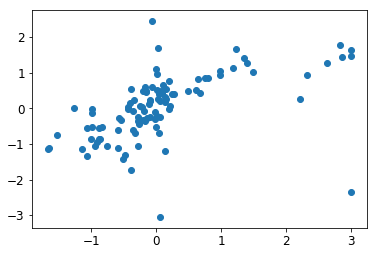

In [299]:
reg = LinearRegression()
reg.fit(X_train, y_train)
scoring(reg, y_test, X_test, y_train, X_train)

Ridge Regression is a regularized version of Linear Regression that forces the learning algorithm minimize the model weights by adding a regularization term to the cost function equal to half the square of the ℓ2 norm of the weight vector

RMSE train 0.48912949353610813
RMSE test 0.6034694511269381
Cross-validated RMSE on Test Data:
[0.61262182 1.18998124 0.73863003]

y_test vs y_pred


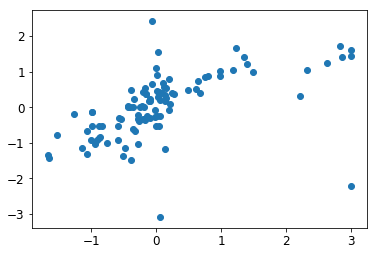

In [300]:
reg = Ridge(alpha=1, solver="cholesky")
reg.fit(X_train, y_train)
scoring(reg, y_test, X_test, y_train, X_train)

Lasso (Least Absolute Shrinkage and Selection Operator) Regression is another regularized version of Linear Regression that adds a regularization term to the cost function using the ℓ1 norm of the weight vector

RMSE train 0.5655623857100329
RMSE test 0.6213642202637357
Cross-validated RMSE on Test Data:
[0.73045954 1.06825951 0.63393811]

y_test vs y_pred


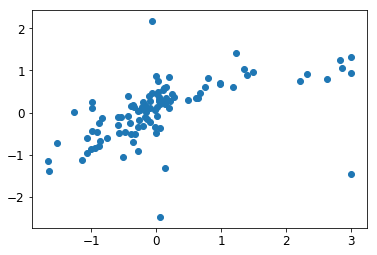

In [301]:
reg = Lasso(alpha=0.1)
reg.fit(X, y)
scoring(reg, y_test, X_test, y_train, X_train)

Elastic Net is a middle ground between Ridge and Lasso Regression. The regularization term is mix of both Ridge and Lasso’s regularization terms. Here the ratio is set to .5, in the middle between lasso and ridge

RMSE train 0.5361235408843865
RMSE test 0.6179366483214431
Cross-validated RMSE on Test Data:
[0.69301189 1.08317607 0.64248548]

y_test vs y_pred


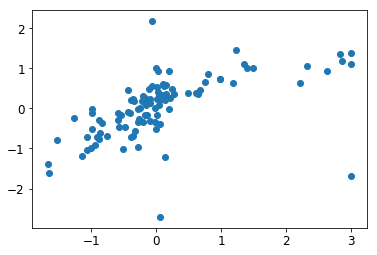

In [302]:
from sklearn.linear_model import ElasticNet
reg = ElasticNet(alpha=0.1, l1_ratio=0.5)
reg.fit(X_train, y_train)

#plot_learning_curves(ElasticNet(), X_train, y_train)
plt.show()
scoring(reg, y_test, X_test, y_train, X_train)

# Summary

Given the management question, It is almost always preferable to avoid plain Linear Regression and use a regularized model like Ridge, Lasso, or Elastic Net. Lsso is preferale over Ridge if only a few features are usefuland  Elastic Net is preferred over Lasso since Lasso may behave erratically when the number of features is greater than the number of training instances or if several features are strongly correlated. Suggestion to management would be additional feature engineering, introducing new/better features, eliminating useless features, or combining redundant ones. because plain regression analysis is prone to error, a regularize model should be recommended. It should be noted however that the model performs better in this analysis on the test set than on the training set. Perhaps further investigation is necessary to validate these results.